In [106]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as npr
import pandas as pd
from scipy.stats import loggamma
import math

%matplotlib inline

In [155]:
import scipy

The Black-Scholes-Merton model for option pricing. The level of stock index $S_T$ at future date T given level $S_0$ as of today.
The Black-Scholes-Merton model for simulating future index level 
$$S_T = S_0 e^{(r-\frac{\sigma^2}{2})T + \sigma\sqrt{T}z}$$

In [9]:
googl = pd.read_csv('/Users/Kevin/Desktop/207/AM207_MC_stock_derivatives/data/googl.csv')
jpm = pd.read_csv('/Users/Kevin/Desktop/207/AM207_MC_stock_derivatives/data/jpm.csv')
msft = pd.read_csv('/Users/Kevin/Desktop/207/AM207_MC_stock_derivatives/data/msft.csv')
sp500 = pd.read_csv('/Users/Kevin/Desktop/207/AM207_MC_stock_derivatives/data/sp500.csv')

In [15]:
googl['Close'].head()
googl.columns

Index([u'Date', u'Open', u'High', u'Low', u'Close', u'Volume'], dtype='object')

# Naive prediction

In [31]:
# Naive prediction 
def naive_predict_return(returns, t_horizon, n_iters):
    # Find mean and std of history prices
    avg_pct_change = returns.mean()
    std = returns.std()
    
    # Assume return is normally distributed
    # returns: n_iters x t_horizon matrix
    results = []
    print avg_pct_change, std
    for i in range(n_iters):
        results.append(np.random.normal(loc=avg_pct_change, scale=std, size=t_horizon))
    return results

In [51]:
def less_naive_predict_return(returns, t_horizon, n_iters, num_slices):
    # Find mean of num_slices of history
    n = len(returns)
    jump_size = n / num_slices
    means = []
    print 'jmp:', jump_size, ' n:',n
    for i in range(1, num_slices):
        means.append(np.mean(returns[(i-1)*jump_size:i*jump_size]))
    mu_mean = np.mean(means)
    mu_std = np.std(means)
    results = []
    print mu, std
    for i in range(n_iters):
        results.append(np.random.normal(loc=np.random.normal(loc=mu_mean,scale=mu_std), scale=?, size=t_horizon))
    return results

0.000870994979264 0.019597909334


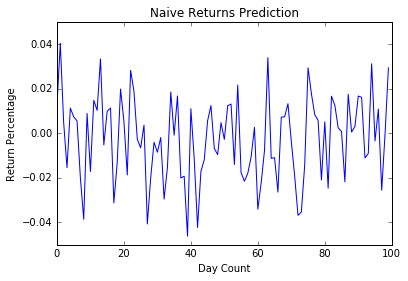

In [59]:
r = naive_predict_return(googl['Close'].pct_change(), 100, 20)
plt.title("Naive Returns Prediction")
plt.plot(r[0])
plt.xlabel("Day Count")
plt.ylabel("Return Percentage")

jmp: 284  n: 2849
0.000873423584207 0.000835103645528


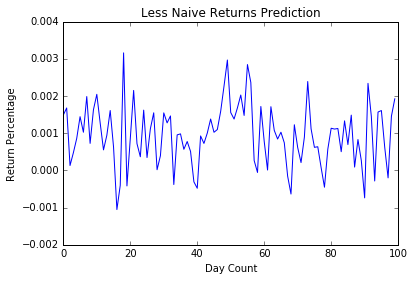

In [60]:
r = less_naive_predict_return(googl['Close'].pct_change(), 100, 20, 10)
plt.plot(r[0])
plt.title("Less Naive Returns Prediction")
plt.xlabel("Day Count")
plt.ylabel("Return Percentage")

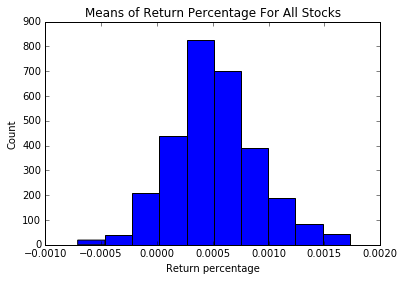

In [78]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

reduced_stock = pd.read_csv('/Users/Kevin/Desktop/207/AM207_MC_stock_derivatives/data/allstock_reduced.csv')

# Plot histogram of mean of returns of all stocks
r_means = reduced_stock.set_index('Date').pct_change().ix[1:].mean(axis=0)
r_stds = reduced_stock.set_index('Date').pct_change().ix[1:].std(axis=0)
filtered = r_means[~is_outlier(r_means)]
plt.hist(filtered)
plt.title("Means of Return Percentage For All Stocks")
plt.xlabel("Return percentage")
plt.ylabel("Count")

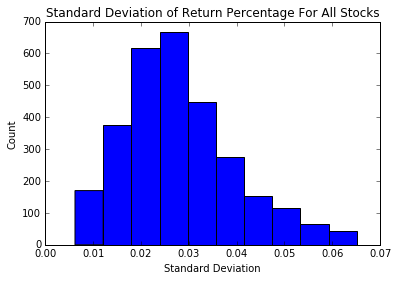

In [79]:
filtered = r_stds[~is_outlier(r_stds)]
plt.hist(filtered)
plt.title("Standard Deviation of Return Percentage For All Stocks")
plt.xlabel("Standard Deviation")
plt.ylabel("Count")

In [117]:
import matplotlib.mlab as mlab
delta = 0.025
x = np.arange(-3.0, 3.0, delta)
y = np.arange(-2.0, 2.0, delta)
X, Y = np.meshgrid(x, y)
Z1 = mlab.bivariate_normal(X, Y, 1.0, 1.0, 0.0, 0.0)
Z2 = mlab.bivariate_normal(X, Y, 1.5, 0.5, 1, 1)
# difference of Gaussians
Z = 10.0 * (Z2 - Z1)

In [138]:
delta = 0.025
x = np.arange(-3.0, 3.0, delta)
y = np.arange(-2.0, 2.0, delta)
X, Y = np.meshgrid(x, y)
Z1 = mlab.bivariate_normal(X, Y, 1.0, 1.0, 0.0, 0.0)
Z2 = mlab.bivariate_normal(X, Y, 1.5, 0.5, 1, 1)
# difference of Gaussians
Z = 10.0 * (Z2 - Z1)
X.shape, Y.shape

((160, 240), (160, 240))

In [159]:
fit_alpha, fit_loc, fit_beta=scipy.stats.gamma.fit(r_stds.values)
print(fit_alpha, fit_loc, fit_beta)

(0.018657353682767362, 0.006202851235792119, 0.20458649075124824)


In [238]:
def logLikelihood(data, k, theta):
    return np.sum(np.log(scipy.stats.gamma.pdf(data, a=k, loc=0, scale=theta)))

logLResults = []
# filtered = r_stds[~is_outlier(r_stds)]
# k, theta = range(100), range(100)
# XX, YY = np.meshgrid(k, theta)
# Z = logLikelihood(filtered,XX, YY)
m = 10
# for k in range(1, m):
#     for theta in range(1, m):
#         logLResults.append((logLikelihood(r_stds.values, k, theta), k, theta))

for k in np.arange(1,5,0.05):
    for theta in np.arange(0.0001,0.0161,0.0002):
        r = logLikelihood(r_stds.values, k, theta)
        logLResults.append((r, k, theta))
l = np.sqrt(np.array(logLResults).shape[0])

Optimal k, theta:  (8434.8948375437758, 3.5000000000000022, 0.0089000000000000017)


/Users/Kevin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':
/Users/Kevin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app
/Users/Kevin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


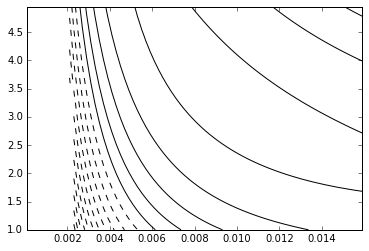

In [239]:
plt.contour(np.array(map(lambda x: x[2], logLResults)).reshape((l,l)),
            np.array(map(lambda x: x[1], logLResults)).reshape((l,l)),
            np.array(map(lambda x: x[0], logLResults)).reshape((l,l)),20,
                 colors='k')
print 'Optimal k, theta: ', logLResults[np.argmax(map(lambda x: x[0], logLResults))]
#print logLResults

(array([   8.,   47.,  144.,  303.,  518.,  743.,  905.,  953.,  932.,
         926.,  802.,  717.,  589.,  510.,  442.,  314.,  258.,  219.,
         168.,  121.,   95.,   70.,   56.,   31.,   34.,   22.,   16.,
          12.,    9.,    4.,    7.,    0.,    5.,    2.,    5.,    4.,
           1.,    4.,    0.,    1.,    1.,    0.,    0.,    0.,    1.,
           0.,    0.,    0.,    0.,    1.]),
 array([  25.03768663,   33.36954823,   41.70140983,   50.03327143,
          58.36513303,   66.69699463,   75.02885623,   83.36071783,
          91.69257943,  100.02444103,  108.35630263,  116.68816423,
         125.02002583,  133.35188743,  141.68374903,  150.01561063,
         158.34747223,  166.67933384,  175.01119544,  183.34305704,
         191.67491864,  200.00678024,  208.33864184,  216.67050344,
         225.00236504,  233.33422664,  241.66608824,  249.99794984,
         258.32981144,  266.66167304,  274.99353464,  283.32539624,
         291.65725784,  299.98911944,  308.32098104,  31

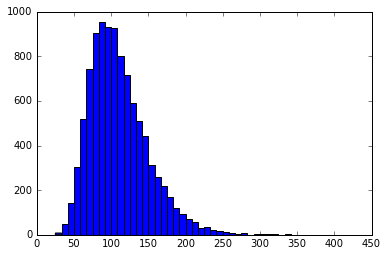

In [5]:
S0 = 100
r = .05
sigma = .25
T = 2.0
I = 10000
ST1 = S0 * np.exp((r-.5*sigma**2) * T + sigma * np.sqrt(T) * npr.standard_normal(I))

plt.hist(ST1, bins = 50)

# Geometrix Brownian motion
Black-Scholes-Merton model in dynamic form
$$S_t = S_{t-\Delta t} e^{(r-\frac{\sigma**2}{2})\Delta t + \sigma z_t\sqrt{\Delta t}}$$

In [28]:
# Number of paths to simulate
I = 10000

# Length of the path
M = 1000

dt = T / M
S = np.zeros((M+1, I))
S[0] = S0
for t in range(1, M+1):
    S[t] = S[t-1] * np.exp((r - 0.5 * sigma**2) * dt +
                          sigma * np.sqrt(dt)*npr.standard_normal(I))

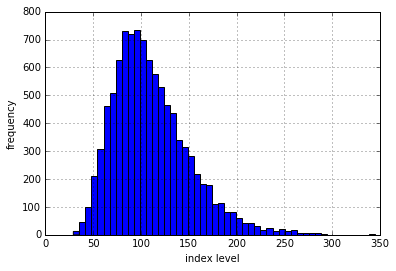

In [25]:
plt.hist(S[-1], bins=50)
plt.xlabel('index level')
plt.ylabel('frequency')
plt.grid(True)

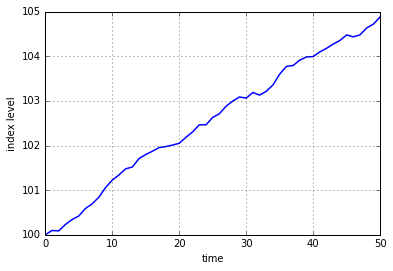

In [85]:
# Plot the first 5 simulated paths
plt.plot(np.average(S[:,:], axis=1), lw=1.5)
plt.xlabel("time")
plt.ylabel("index level")
plt.grid(True)

In [47]:
# Stochastic volatility
S0 = 100
r = .05
v0 = .1
kappa = 3.0
theta = .25
sigma = .1
rho = .6
T = 1.0

# Correlation between two stochastic processes
corr_mat = np.zeros((2,2))
corr_mat[0, :] = [1.0, rho]
corr_mat[1, :] = [rho, 1.0]
cho_mat = np.linalg.cholesky(corr_mat)
cho_mat

array([[ 1. ,  0. ],
       [ 0.6,  0.8]])

In [58]:
M = 50
I = 10000
ran_num = npr.standard_normal((2, M+1, I))
dt = T/M
v = np.zeros_like(ran_num[0])
vh = np.zeros_like(v)
v[0] = v0
vh[0] = v0
for t in range(1, M+1):
    ran = np.dot(cho_mat, ran_num[:, t, :])
    vh[t] = (vh[t-1] + kappa * (theta - np.maximum(vh[t-1], 0)) * dt +
             sigma * np.sqrt(np.maximum(vh[t-1], 0)) * np.sqrt(dt) * ran[1])
v = np.maximum(vh, 0)

In [59]:
S = np.zeros_like(ran_num[0])
S[0] = S0
for t in range(1, M+1):
    ran = np.dot(cho_mat, ran_num[:, t, :])
    S[t] = S[t-1] * np.exp((r - .5 * v[t]) * dt +
                          np.sqrt(v[t]) * ran[0] * np.sqrt(dt))
    

In [55]:
ran_num[0][0].shape

(10000,)

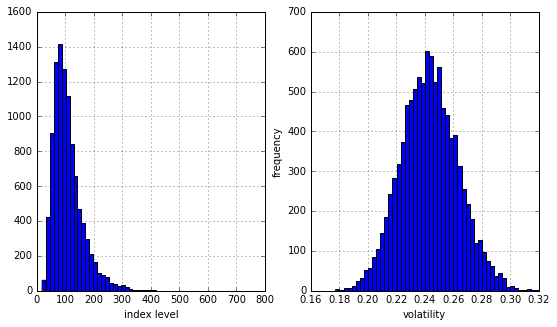

In [60]:
# Volatility drifts positive and converges at .25
fit, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,5))
ax1.hist(S[-1], bins=50)
ax1.set_xlabel('index level')
ax2.set_ylabel('frequency')
ax1.grid(True)
ax2.hist(v[-1], bins=50)
ax2.set_xlabel('volatility')
ax2.grid(True)

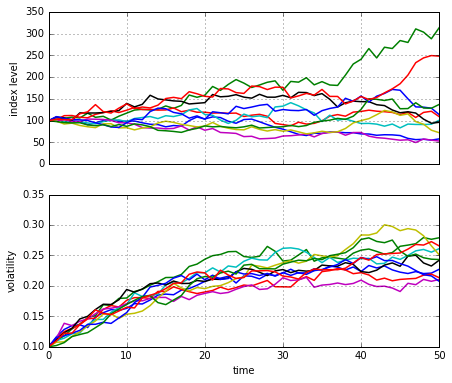

In [62]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(7,6))
ax1.plot(S[:, :10], lw=1.5)
ax1.set_ylabel('index level')
ax1.grid(True)
ax2.plot(v[:, :10], lw=1.5)
ax2.set_xlabel('time')
ax2.set_ylabel('volatility')
ax2.grid(True)

In [69]:
# Jump diffusion
S0 = 100
r = .05
sigma = .2
lamb = .75
mu = -0.6
delta = .25
T = 1.0

M = 50
I = 10000
dt = T/M
rj = lamb * (np.exp(mu + .5 * delta **2) - 1)
S = np.zeros((M+1, I))
S[0] = S0
sn1 = npr.standard_normal((M+1, I))
sn2 = npr.standard_normal((M+1, I))
poi = npr.poisson(lamb * dt, (M+1, I))
for t in range(1, M+1, 1):
    S[t] = S[t-1] * (np.exp((r - rj - .5 * sigma **2) * dt +
                           sigma * np.sqrt(dt) * sn1[t])
                    + (np.exp(mu + delta * sn2[t]) - 1)
                    * poi[t])
    S[t] = np.maximum(S[t], 0)

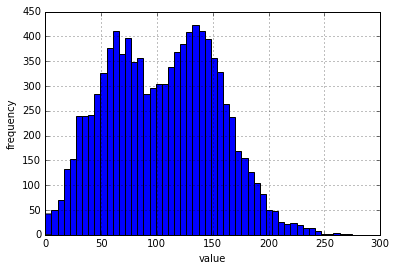

In [70]:
plt.hist(S[-1], bins=50)
plt.xlabel('value')
plt.ylabel('frequency')
plt.grid(True)

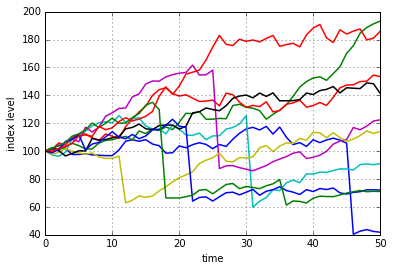

In [71]:
plt.plot(S[:, :10], lw=1.5)
plt.xlabel('time')
plt.ylabel('index level')
plt.grid(True)

In [72]:
def gen_sn(M, I, anti_paths=True, mo_match=True):
    if anti_paths is True:
        sn = npr.standard_normal((M+1, I/2))
        sn = np.concatenate((sn, -sn), axis=1)
    else:
        sn = npr.standard_normal((M+1, I))
    if mo_match is True:
        sn = (sn - sn.mean()) / sn.std()
    return sn
# European options
S0 = 100
r = .05
sigma = .25
T = 1.0
I = 50000

# static approach
# Option pricing using Monte carlo simulation
def gbm_mcs_stat(K):
    sn = gen_sn(1, I)
    ST = S0 * np.exp((r - .5 * sigma ** 2) * T + 
                    sigma * np.sqrt(T) * sn[1])
    hT = np.maximum(ST - K, 0)
    C0 = np.exp(-r * T) * 1/I * np.sum(hT)
    return C0

gbm_mcs_stat(K=105.)

10.042048944866236

In [76]:
# Dynamic approach
# Valuation of european options in BSM by Monte carlo sim

M = 50
def gbm_mcs_dyna(K, option='call'):
    """
    K: (positive) strike price of option
    option: type of option 'call', 'put'
    """
    dt = T/M
    S = np.zeros((M+1, I))
    S[0] = S0
    sn = gen_sn(M, I)
    for t in range(1, M+1):
        S[t] = S[t-1] * np.exp((r - .5 * sigma ** 2) * dt
                              + sigma * np.sqrt(dt) * sn[t])
    if option == 'call':
        hT = np.maximum(S[-1]-K, 0)
    else:
        hT = np.maximum(K - S[-1], 0)
    C0 = np.exp(-r * T) * 1 / I * np.sum(hT)
    return C0
print gbm_mcs_dyna(K=110., option='call')
print gbm_mcs_dyna(K=110., option='put')

7.96998680729
12.6608556968


In [79]:
# Black-Scholes-Merton option pricing formula 
def bsm_call_value(S0,K,T,r,sigma):
    from math import log,sqrt,exp
    from scipy import stats
    
    S0 = float(S0)
    d1 = (log(S0 / K ) + (r + 0.5 * sigma ** 2) * T) /(sigma * sqrt(T))
    d2 = (log(S0 / K ) + (r - 0.5 * sigma ** 2) * T) /(sigma * sqrt(T))
    value = (S0 * stats.norm.cdf(d1,0.0,1.0)
            - K * exp(-r * T) * stats.norm.cdf(d2,0.0,1.0))
    return value

stat_res = []
dyna_res = []
anal_res = []
k_list = np.arange(80.,120.1,5.)
np.random.seed(20000)
for K in k_list:
    stat_res.append(gbm_mcs_stat(K))
    dyna_res.append(gbm_mcs_dyna(K))
    anal_res.append(bsm_call_value(S0, K, T, r, sigma))
stat_res = np.array(stat_res)
dyna_res = np.array(dyna_res)
anal_res = np.array(anal_res)

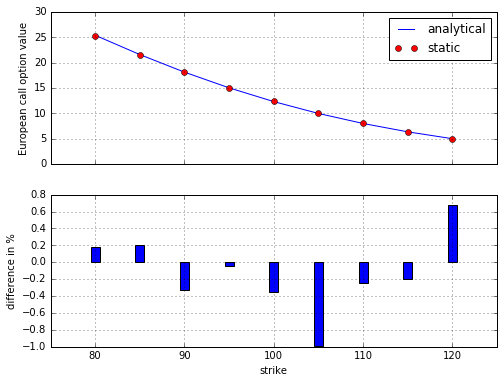

In [80]:
# Compare BSM with Monte carlo
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8,6))
ax1.plot(k_list, anal_res, 'b', label='analytical')
ax1.plot(k_list, stat_res, 'ro', label='static')
ax1.set_ylabel('European call option value')
ax1.grid(True)
ax1.legend(loc=0)
ax1.set_ylim(ymin=0)
wi = 1.0
ax2.bar(k_list - wi/2, (anal_res - stat_res)/anal_res * 100, wi)
ax2.set_xlabel('strike')
ax2.set_ylabel('difference in %')
ax2.set_xlim(left=75, right=125)
ax2.grid(True)

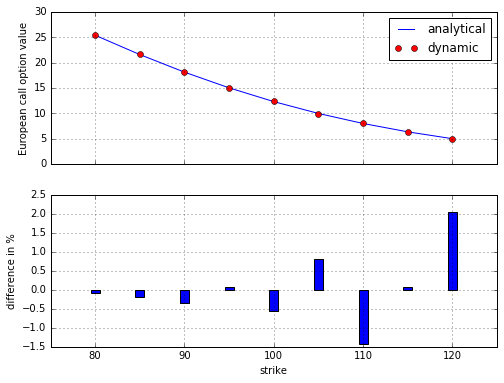

In [81]:
# Dynamic simulation
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8,6))
ax1.plot(k_list, anal_res, 'b', label='analytical')
ax1.plot(k_list, dyna_res, 'ro', label='dynamic')
ax1.set_ylabel('European call option value')
ax1.grid(True)
ax1.legend(loc=0)
ax1.set_ylim(ymin=0)
wi = 1.0
ax2.bar(k_list - wi/2, (anal_res - dyna_res)/anal_res * 100, wi)
ax2.set_xlabel('strike')
ax2.set_ylabel('difference in %')
ax2.set_xlim(left=75, right=125)
ax2.grid(True)